# Gemstone Analysis using ResNet18 and ResNet50

ResNet18 and ResNet50 models pretrained on ImageNet dataset was applied to the gemstone images for feature extraction. 

The codes were based on the following resources and were executed on the Free GPU offered by Google Colab.

1.   Skorch tutorial https://github.com/skorch-dev/skorch/blob/master/notebooks/Transfer_Learning.ipynb
2.   https://medium.datadriveninvestor.com/train-a-cnn-using-skorch-for-mnist-digit-recognition-53d7d2f971c7
3.   PyTorch tutorial provided by Sasank Chilamkurthy https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html and subsequent modification by Giacomo Tarroni of City, University of London.

## Initial set up

**Set up device :** Go to *Runtime/Change runtime type* in the Colab menu and changing *Hardware acceleration* from *None* to *GPU*.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install Skorch to run the codes in Google Colab

In [ ]:
! [ ! -z "$COLAB_GPU" ] && pip install torch torchvision pillow==7.1.2 skorch

     |████████████████████████████████| 155 kB 5.3 MB/s 


In [ ]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import skorch
from skorch.callbacks import LRScheduler, Checkpoint
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os 
import pickle
import seaborn as sns
from skorch import NeuralNetClassifier
from sklearn.metrics import accuracy_score, top_k_accuracy_score, confusion_matrix
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [ ]:
print(torch.cuda.get_device_name(0))

Tesla K80


In [ ]:
# Import dataset
! git clone https://github.com/hybchow/gems

Cloning into 'gems'...
remote: Enumerating objects: 5040, done.
remote: Counting objects: 100% (5040/5040), done.
remote: Compressing objects: 100% (4834/4834), done.
remote: Total 5040 (delta 209), reused 5037 (delta 206), pack-reused 0
Receiving objects: 100% (5040/5040), 62.20 MiB | 30.32 MiB/s, done.
Resolving deltas: 100% (209/209), done.


In [ ]:
# Set seed to 1
seed = 1
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

## Loading the Data


Data augmentation techniques such as cropping to 224 x 224 pixels and horizontal flips were applied to the training images. Both train and validiation images were normalized with mean: [0.485, 0.456, 0.406], and standard deviation: [0.229, 0.224, 0.225], which were the means and standard deviations of the ImageNet images. These values were used because the pretrained model was trained on ImageNet.

In [ ]:
# Data augmentation and normalization for training set
# Just normalization for test set
data_means = [0.485, 0.456, 0.406]
data_stds = [0.229, 0.224, 0.225]

data_transforms = {
    'train_masked': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)
    ]),
    'test_masked': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)
    ]),
}

In [ ]:
# Define the path where the dataset was saved
data_dir = '/content/gems/'

In [ ]:
# Load the masked images
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train_masked', 'test_masked']}

# Compute the weight for each image
def compute_weight(images):                        
    count = [0] * 68                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * 68                                     
    N = float(sum(count))                                                   
    for i in range(68):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, (image_datasets, label) in enumerate(images):                                          
        weight[idx] = weight_per_class[label]                                  
    return weight                                                                
                                                                                
# Create a weighted sampler for training data                   
weights = compute_weight(image_datasets['train_masked'])                                                                
weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights), replacement=True)                     

dataloaders = {}                                                                               
dataloaders['train_masked'] = torch.utils.data.DataLoader(image_datasets['train_masked'], batch_size=16,                              
                                                             sampler = sampler, num_workers=2)    

# Create sampler for test data
dataloaders['test_masked'] = torch.utils.data.DataLoader(image_datasets['test_masked'], batch_size=16,
                                             shuffle=True, num_workers=2)

In [ ]:
# Display dataset sizes and class names
dataset_sizes = {x: len(image_datasets[x]) for x in ['train_masked', 'test_masked']}
class_names = image_datasets['test_masked'].classes
print(dataset_sizes)
print(class_names)

{'train_masked': 2042, 'test_masked': 284}
['Alexandrite', 'Almandine', 'Amazonite', 'Amber', 'Amethyst', 'Ametrine', 'Andradite', 'Aquamarine', 'Aventurine Green', 'Aventurine Yellow', 'Benitoite', 'Beryl Golden', 'Bixbite', 'Bloodstone', 'Blue Lace Agate', 'Carnelian', 'Chalcedony', 'Chalcedony Blue', 'Chrome Diopside', 'Chrysoberyl', 'Chrysocolla', 'Chrysoprase', 'Citrine', 'Coral', 'Diamond', 'Diaspore', 'Dumortierite', 'Emerald', 'Fluorite', 'Hessonite', 'Iolite', 'Jasper', 'Kunzite', 'Kyanite', 'Lapis Lazuli', 'Malachite', 'Onyx Black', 'Onyx Green', 'Onyx Red', 'Peridot', 'Prehnite', 'Pyrite', 'Pyrope', 'Quartz Beer', 'Quartz Lemon', 'Quartz Rutilated', 'Quartz Smoky', 'Rhodochrosite', 'Rhodolite', 'Rhodonite', 'Ruby', 'Sapphire Blue', 'Sapphire Pink', 'Sapphire Purple', 'Sapphire Yellow', 'Serpentine', 'Sodalite', 'Spessartite', 'Sphene', 'Sunstone', 'Tanzanite', 'Tigers Eye', 'Topaz', 'Tourmaline', 'Tsavorite', 'Turquoise', 'Zircon', 'Zoisite']


## Visualizing a few images

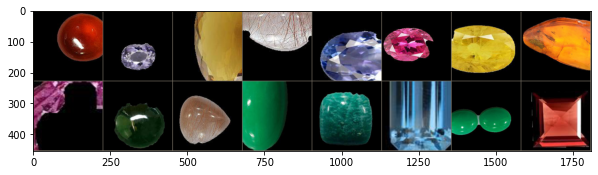

In [ ]:
# Define a function to display the image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.asarray(data_stds) * inp + np.asarray(data_means)
    inp = np.clip(inp, 0, 1)       # Clip to intensity outliers to [0, 1] range
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


# Get a batch of training data
first_inputs, first_classes = next(iter(dataloaders['train_masked']))

# Make a grid from batch
out = torchvision.utils.make_grid(first_inputs)


plt.figure(figsize=(10, 15))
imshow(out)
plt.show()
print([class_names[x] for x in first_classes])


## Training the ResNet18 model

The pre-trained ResNet18 was used as a feature extractor. The first layers of the ResNet18 were "frozen" during training (i.e. weight updates were avoided) and only the final layer was trained. The learning rate was scheduled to change every 7 epochs. The model with the best validation accuracy was saved as the best model.

In [ ]:
# Load a pre-trained model ResNet18
class PretrainedModel(nn.Module):
    def __init__(self, output_features):
        super().__init__()
        model = models.resnet18(pretrained=True)
        # Create a new fully-connected layer for 68 target classes and replace the original one in Resnet18
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, output_features)
        self.model = model
        
    def forward(self, x):
        return self.model(x)

In [ ]:
# Create a LRScheduler callback which scales learning rate by a factor of 0.1 every 7 epochs
lrscheduler = LRScheduler(
    policy='StepLR', step_size=7, gamma=0.1)

['Hessonite', 'Iolite', 'Quartz Beer', 'Quartz Rutilated', 'Tanzanite', 'Tourmaline', 'Sapphire Yellow', 'Amber', 'Sapphire Pink', 'Serpentine', 'Quartz Rutilated', 'Chrysoprase', 'Amazonite', 'Aquamarine', 'Chrysoprase', 'Pyrope']


In [ ]:
# Create a Checkpoint callback which saves the best model by by monitoring the validation accuracy.
checkpoint = Checkpoint(
    f_params='best_model.pt', monitor='valid_acc_best')

In [ ]:
# Create a Freezer to freeze all weights besides the final layer named model.fc:
from skorch.callbacks import Freezer
freezer = Freezer(lambda x: not x.startswith('model.fc'))

In [ ]:
# Define Convolutional Neural Network classifier
resnet18 = NeuralNetClassifier(
    PretrainedModel, 
    criterion=nn.CrossEntropyLoss,
    lr=0.001,
    batch_size=16,
    max_epochs=25,
    module__output_features=68,
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=True,
    iterator_train__num_workers=2,
    iterator_valid__num_workers=2, 
    train_split=skorch.dataset.CVSplit(cv=5, stratified=True),
    callbacks=[('lrscheduler', lrscheduler),('checkpoint', checkpoint),('freezer', freezer)],
    device=device
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: CVSplit is deprecated, use the new name ValidSplit instead
  


In [ ]:
# Train model
start_time = time.time()
resnet18.fit(image_datasets['train_masked'], np.array([y for X,y in image_datasets['train_masked']]))

# Display the training time
time_elapsed = time.time() - start_time
print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

  epoch    train_loss    valid_acc    valid_loss    cp      lr      dur
-------  ------------  -----------  ------------  ----  ------  -------
      1        4.0833       0.1320        3.7204     +  0.0010  12.0591
      2        3.4864       0.3056        3.1766     +  0.0010  10.6153
      3        3.0449       0.4083        2.7395     +  0.0010  10.5210
      4        2.6151       0.4230        2.5164     +  0.0010  10.5478
      5        2.3464       0.5086        2.2536     +  0.0010  10.5209
      6        2.1282       0.4988        2.0809        0.0010  10.6033
      7        1.9730       0.5061        1.9863        0.0010  10.5134
      8        1.7945       0.4988        2.0398        0.0001  10.5310
      9        1.8128       0.5452        1.8949     +  0.0001  10.6544
     10        1.8016       0.5281        1.9582        0.0001  10.5891
     11        1.7634       0.5501        1.9077     +  0.0001  10.5278
     12        1.7505       0.5281        2.0136        0.0001  

In [ ]:
# Load the ResNet model with the highest validation accuracy
best_resnet18 = NeuralNetClassifier(
    PretrainedModel, 
    criterion=nn.CrossEntropyLoss,
    lr=0.001,
    batch_size=16,
    max_epochs=25,
    module__output_features=68,
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=True,
    iterator_train__num_workers=2,
    train_split=None, 
    callbacks=[ ('lrscheduler', lrscheduler),('freezer', freezer)],
    device=device
)
best_resnet18.initialize()
best_resnet18.load_params(checkpoint= Checkpoint(f_params='best_model.pt'))

In [ ]:
# Fit best model to training data
best_resnet18.fit(image_datasets['train_masked'], np.array([y for X,y in image_datasets['train_masked']]))

Re-initializing module because the following parameters were re-set: output_features.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss      lr      dur
-------  ------------  ------  -------
      1        4.0462  0.0010  10.8051
      2        3.3567  0.0010  10.6817
      3        2.8540  0.0010  10.6011
      4        2.4396  0.0010  10.6572
      5        2.1718  0.0010  10.6163
      6        1.9743  0.0010  10.7003
      7        1.8060  0.0010  10.5234
      8        1.7098  0.0001  10.5223
      9        1.6539  0.0001  10.4085
     10        1.6453  0.0001  10.6637
     11        1.6355  0.0001  10.4793
     12        1.6185  0.0001  10.5172
     13        1.6206  0.0001  10.5862
     14        1.5889  0.0001  10.6114
     15        1.6000  0.0000  10.6817
     16        1.5729  0.0000  10.6392
     17        1.5704  0.0000  10.7006
     18        1.5835  0.0000  10.8202
     19        1.5718  0.0000  10.6214
     20        1.5760  0.0000  10.5597
  

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=PretrainedModel(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)

In [ ]:
# Separate dataset into images and targets
train_images = image_datasets['train_masked']
train_target = np.array([y for X,y in image_datasets['train_masked']])
test_images = image_datasets['test_masked']
test_target = np.array([y for X,y in image_datasets['test_masked']])

# Make predictions on training data with the best model
train_pred = best_resnet18.predict(train_images)
train_pred_proba = best_resnet18.predict_proba(train_images)

# Make predictions on test data with the best model
test_time_start = time.time()
test_pred = best_resnet18.predict(test_images)
test_time = time.time() - test_time_start 
test_pred_proba = best_resnet18.predict_proba(test_images)

# Evaluate accuracy of the best esimator with training data
train_accuracy = accuracy_score(train_target, train_pred)
    
# Evaluate accuracy of the best estimator with test data
test_accuracy = accuracy_score(test_target, test_pred)

# Evaluate top 5 accuracy of the best esimator with training data
train_top5_accuracy = top_k_accuracy_score(train_target, train_pred_proba, k=5)
    
# Evaluate top 5 accuracy of the best estimator with test data
test_top5_accuracy = top_k_accuracy_score(test_target, test_pred_proba, k=5)


print("Training accuracy = %.6f"%train_accuracy)
print("Test accuracy = %.6f"%test_accuracy)
print("Training top 5 accuracy = %.6f"%train_top5_accuracy)
print("Test top 5 accuracy = %.6f"%test_top5_accuracy)
print("Training computation time = %.6f"%time_elapsed)
print("Test computation time = %.6f" %test_time)

Training accuracy = 0.712047
Test accuracy = 0.619718
Training top 5 accuracy = 0.939765
Test top 5 accuracy = 0.894366
Training computation time = 293.053000
Test computation time = 2.211962


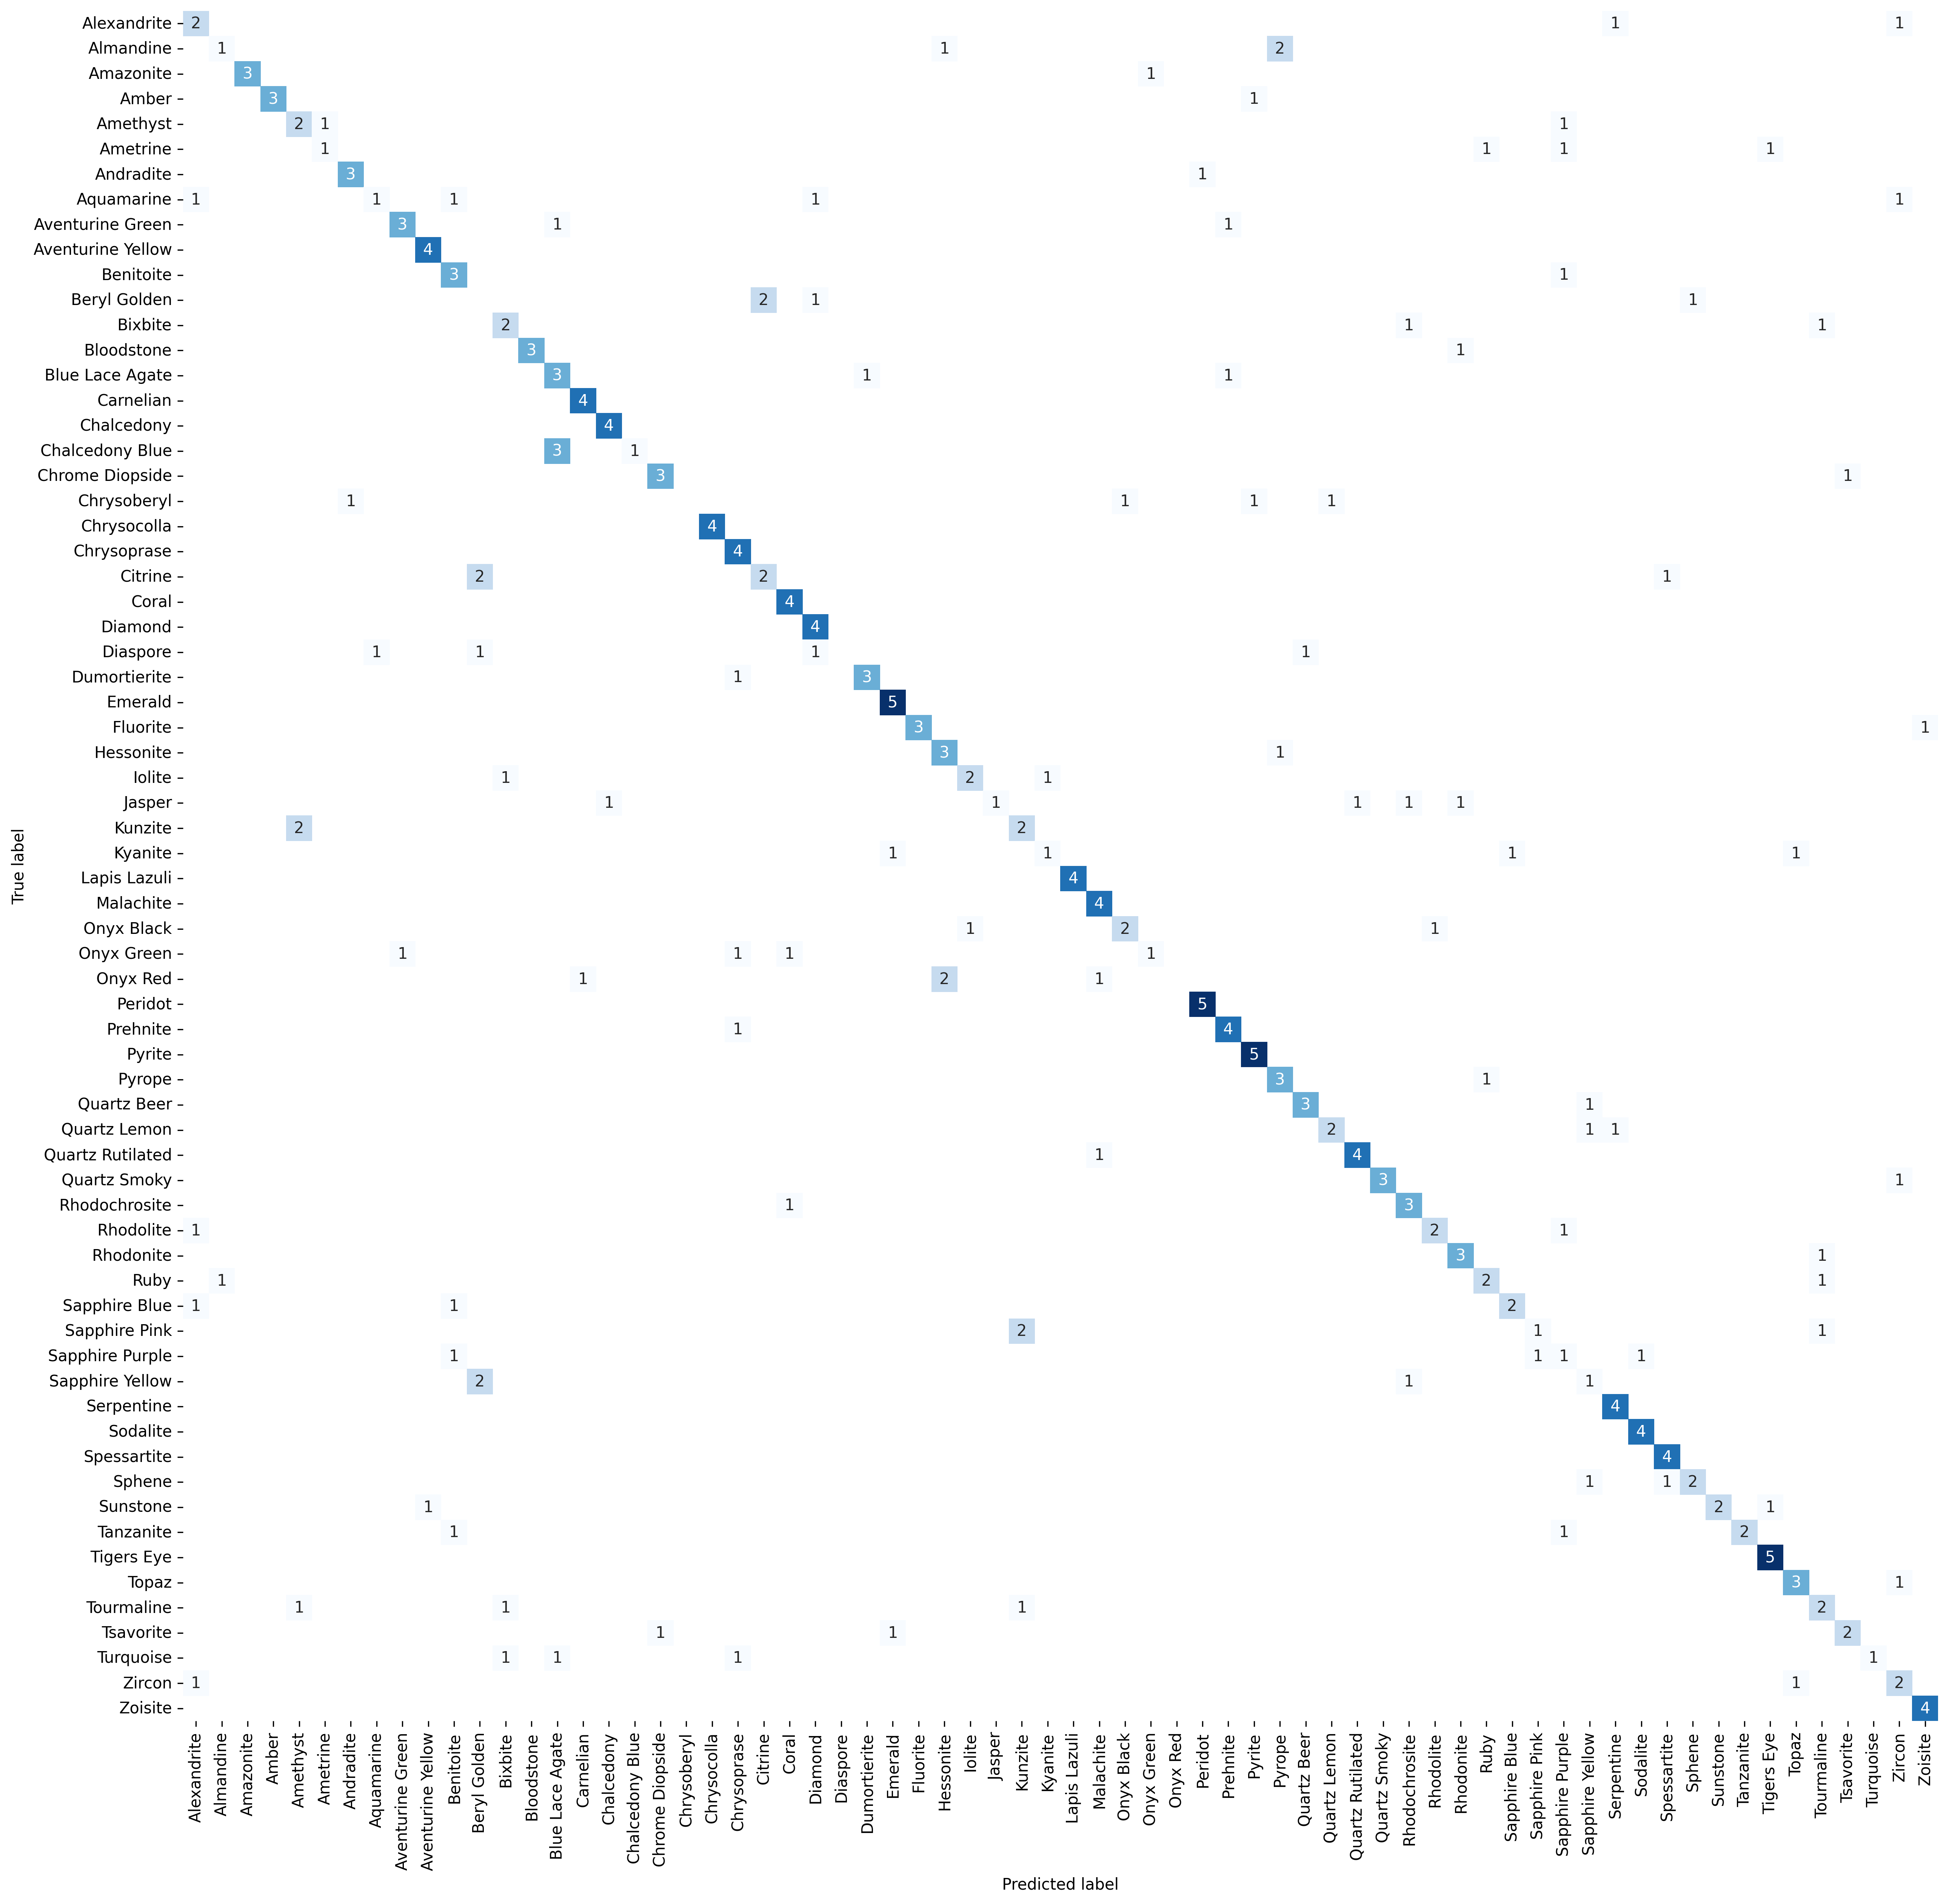

In [ ]:
gemstone_classes = image_datasets['test_masked'].classes
# Display confusion matrix of the best Random Forest model
fig= plt.figure(figsize = (20,20), dpi=300)
ax = plt.subplot()
cm = confusion_matrix(test_target, test_pred)
cm_mask = np.zeros((cm.shape[0], cm.shape[0]), dtype=int)
for i in range(cm.shape[0]):
    for j in range(cm.shape[0]):
        cm_mask[i][j] = cm[i][j] == 0
sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', cbar=False, mask=cm_mask)
plt.xlabel('Predicted label')
plt.ylabel('True label')
ax.set_xticks([x+0.5 for x in range(68)])
ax.set_xticklabels(sorted(gemstone_classes), rotation=90)
ax.set_yticks([x+0.5 for x in range(68)])
ax.set_yticklabels(sorted(gemstone_classes), rotation=0)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_target, test_pred, target_names=gemstone_classes))

                   precision    recall  f1-score   support

      Alexandrite       0.33      0.50      0.40         4
        Almandine       0.50      0.25      0.33         4
        Amazonite       1.00      0.75      0.86         4
            Amber       1.00      0.75      0.86         4
         Amethyst       0.40      0.50      0.44         4
         Ametrine       0.50      0.25      0.33         4
        Andradite       0.75      0.75      0.75         4
       Aquamarine       0.50      0.20      0.29         5
 Aventurine Green       0.75      0.60      0.67         5
Aventurine Yellow       0.80      1.00      0.89         4
        Benitoite       0.43      0.75      0.55         4
     Beryl Golden       0.00      0.00      0.00         4
          Bixbite       0.40      0.50      0.44         4
       Bloodstone       1.00      0.75      0.86         4
  Blue Lace Agate       0.38      0.60      0.46         5
        Carnelian       0.80      1.00      0.89       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


True classes: ['Tigers Eye', 'Bixbite', 'Blue Lace Agate', 'Kunzite', 'Tourmaline', 'Quartz Beer', 'Carnelian', 'Bloodstone', 'Iolite', 'Diamond', 'Almandine', 'Pyrite', 'Jasper', 'Chrysoberyl', 'Onyx Green', 'Diamond']
Predicted classes: ['Tigers Eye', 'Rhodochrosite', 'Dumortierite', 'Amethyst', 'Bixbite', 'Quartz Beer', 'Carnelian', 'Bloodstone', 'Iolite', 'Diamond', 'Pyrope', 'Pyrite', 'Rhodonite', 'Pyrite', 'Chrysoprase', 'Diamond']


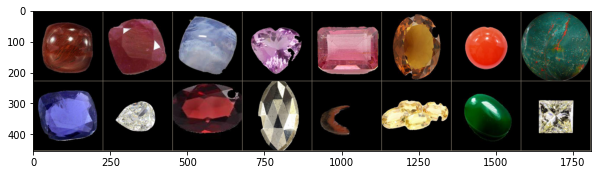

In [ ]:
# Define a function to display the image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.asarray(data_stds) * inp + np.asarray(data_means)
    inp = np.clip(inp, 0, 1)       # Clip to intensity outliers to [0, 1] range
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


# Get a batch of training data
first_inputs, first_classes = next(iter(dataloaders['test_masked']))

# Make a grid from batch
out = torchvision.utils.make_grid(first_inputs)

plt.figure(figsize=(10, 15))
imshow(out)
print('True classes: ' +str([class_names[x] for x in first_classes]))
print('Predicted classes: ' +str([class_names[y] for y in best_resnet18.predict(first_inputs)]))
plt.show()

## Training the Resnet50 model

In [ ]:
# Load a pre-trained model ResNet50
class PretrainedModel2(nn.Module):
    def __init__(self, output_features):
        super().__init__()
        model = models.resnet50(pretrained=True)
        # Create a new fully-connected layer for 68 target classes and replace the original one in Resnet18
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, output_features)
        self.model = model
        
    def forward(self, x):
        return self.model(x)

In [ ]:
# Create a LRScheduler callback which scales learning rate by a factor of 0.1 every 7 epochs
lrscheduler = LRScheduler(
    policy='StepLR', step_size=7, gamma=0.1)

In [ ]:
# Create a Checkpoint callback which saves the best model by by monitoring the validation accuracy.
checkpoint = Checkpoint(
    f_params='best_model2.pt', monitor='valid_acc_best')

In [ ]:
# Create a Freezer to freeze all weights besides the final layer named model.fc:
from skorch.callbacks import Freezer
freezer = Freezer(lambda x: not x.startswith('model.fc'))

In [ ]:
# Define Convolutional Neural Network classifier
resnet50 = NeuralNetClassifier(
    PretrainedModel2, 
    criterion=nn.CrossEntropyLoss,
    lr=0.001,
    batch_size=16,
    max_epochs=25,
    module__output_features=68,
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=True,
    iterator_train__num_workers=2,
    iterator_valid__num_workers=2,
    train_split=skorch.dataset.CVSplit(cv=5, stratified=True),
    callbacks=[('lrscheduler', lrscheduler), ('checkpoint', checkpoint), ('freezer', freezer)],
    device=device
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: CVSplit is deprecated, use the new name ValidSplit instead
  


In [ ]:
# Train model
start_time = time.time()
resnet50.fit(image_datasets['train_masked'], np.array([y for X,y in image_datasets['train_masked']]))

# Display the training time
time_elapsed = time.time() - start_time
print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

  epoch    train_loss    valid_acc    valid_loss    cp      lr      dur
-------  ------------  -----------  ------------  ----  ------  -------
      1        4.1058       0.1565        3.7796     +  0.0010  20.5574
      2        3.5993       0.3325        3.3577     +  0.0010  17.2601
      3        3.1613       0.3814        2.9913     +  0.0010  17.2225
      4        2.7879       0.4645        2.6701     +  0.0010  17.2846
      5        2.4910       0.5306        2.4398     +  0.0010  17.1629
      6        2.2827       0.5232        2.2876        0.0010  17.3019
      7        2.1044       0.5061        2.1547        0.0010  17.3216
      8        1.9322       0.5795        2.0657     +  0.0001  17.1620
      9        1.9294       0.5623        2.0827        0.0001  17.1563
     10        1.9029       0.5795        2.0537        0.0001  17.1671
     11        1.8686       0.5648        1.9937        0.0001  17.2460
     12        1.8879       0.5477        2.0676        0.0001  

In [ ]:
# Load the ResNet model with the highest validation accuracy
best_resnet50 = NeuralNetClassifier(
    PretrainedModel2, 
    criterion=nn.CrossEntropyLoss,
    lr=0.001,
    batch_size=16,
    max_epochs=25,
    module__output_features=68,
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=True,
    iterator_train__num_workers=2,
    train_split=None,
    callbacks=[('lrscheduler', lrscheduler), ('freezer', freezer)],
    device=device
)
best_resnet50.initialize()
best_resnet50.load_params(checkpoint= Checkpoint(f_params='best_model2.pt'))

In [ ]:
# Fit best model to training data
best_resnet50.fit(image_datasets['train_masked'], np.array([y for X,y in image_datasets['train_masked']]))

Re-initializing module because the following parameters were re-set: output_features.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss      lr      dur
-------  ------------  ------  -------
      1        4.0102  0.0010  18.3283
      2        3.4103  0.0010  17.1380
      3        2.9321  0.0010  17.1181
      4        2.5658  0.0010  17.0614
      5        2.2694  0.0010  17.1655
      6        2.0717  0.0010  17.0742
      7        1.9166  0.0010  17.0466
      8        1.7984  0.0001  17.0217
      9        1.7404  0.0001  17.1918
     10        1.7262  0.0001  17.1740
     11        1.7034  0.0001  17.1457
     12        1.7066  0.0001  17.1649
     13        1.6987  0.0001  17.0419
     14        1.6876  0.0001  17.0544
     15        1.6560  0.0000  17.1255
     16        1.6535  0.0000  17.1219
     17        1.6511  0.0000  17.0983
     18        1.6787  0.0000  17.1007
     19        1.6287  0.0000  16.9710
     20        1.6975  0.0000  17.0905
  

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=PretrainedModel2(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, 

In [ ]:
# Separate dataset into images and targets
train_images = image_datasets['train_masked']
train_target = np.array([y for X,y in image_datasets['train_masked']])
test_images = image_datasets['test_masked']
test_target = np.array([y for X,y in image_datasets['test_masked']])

# Make predictions with the best model on training data
train_pred = best_resnet50.predict(train_images)
train_pred_proba = best_resnet50.predict_proba(train_images)

# Make predictions with the best model on test data
test_time_start = time.time()
test_pred = best_resnet50.predict(test_images)
test_time = time.time() - test_time_start 
test_pred_proba = best_resnet50.predict_proba(test_images)

# Evaluate accuracy of the best esimator with training data
train_accuracy = accuracy_score(train_target, train_pred)
    
# Evaluate accuracy of the best estimator with test data
test_accuracy = accuracy_score(test_target, test_pred)

# Evaluate top 5 accuracy of the best esimator with training data
train_top5_accuracy = top_k_accuracy_score(train_target, train_pred_proba, k=5)
    
# Evaluate top 5 accuracy of the best estimator with test data
test_top5_accuracy = top_k_accuracy_score(test_target, test_pred_proba, k=5)


print("Training accuracy = %.6f"%train_accuracy)
print("Test accuracy = %.6f"%test_accuracy)
print("Training top 5 accuracy = %.6f"%train_top5_accuracy)
print("Test top 5 accuracy = %.6f"%test_top5_accuracy)
print("Training computation time = %.6f"%time_elapsed)
print("Test computation time = %.6f" %test_time)

Training accuracy = 0.734084
Test accuracy = 0.633803
Training top 5 accuracy = 0.964740
Test top 5 accuracy = 0.915493
Training computation time = 449.086838
Test computation time = 4.524391


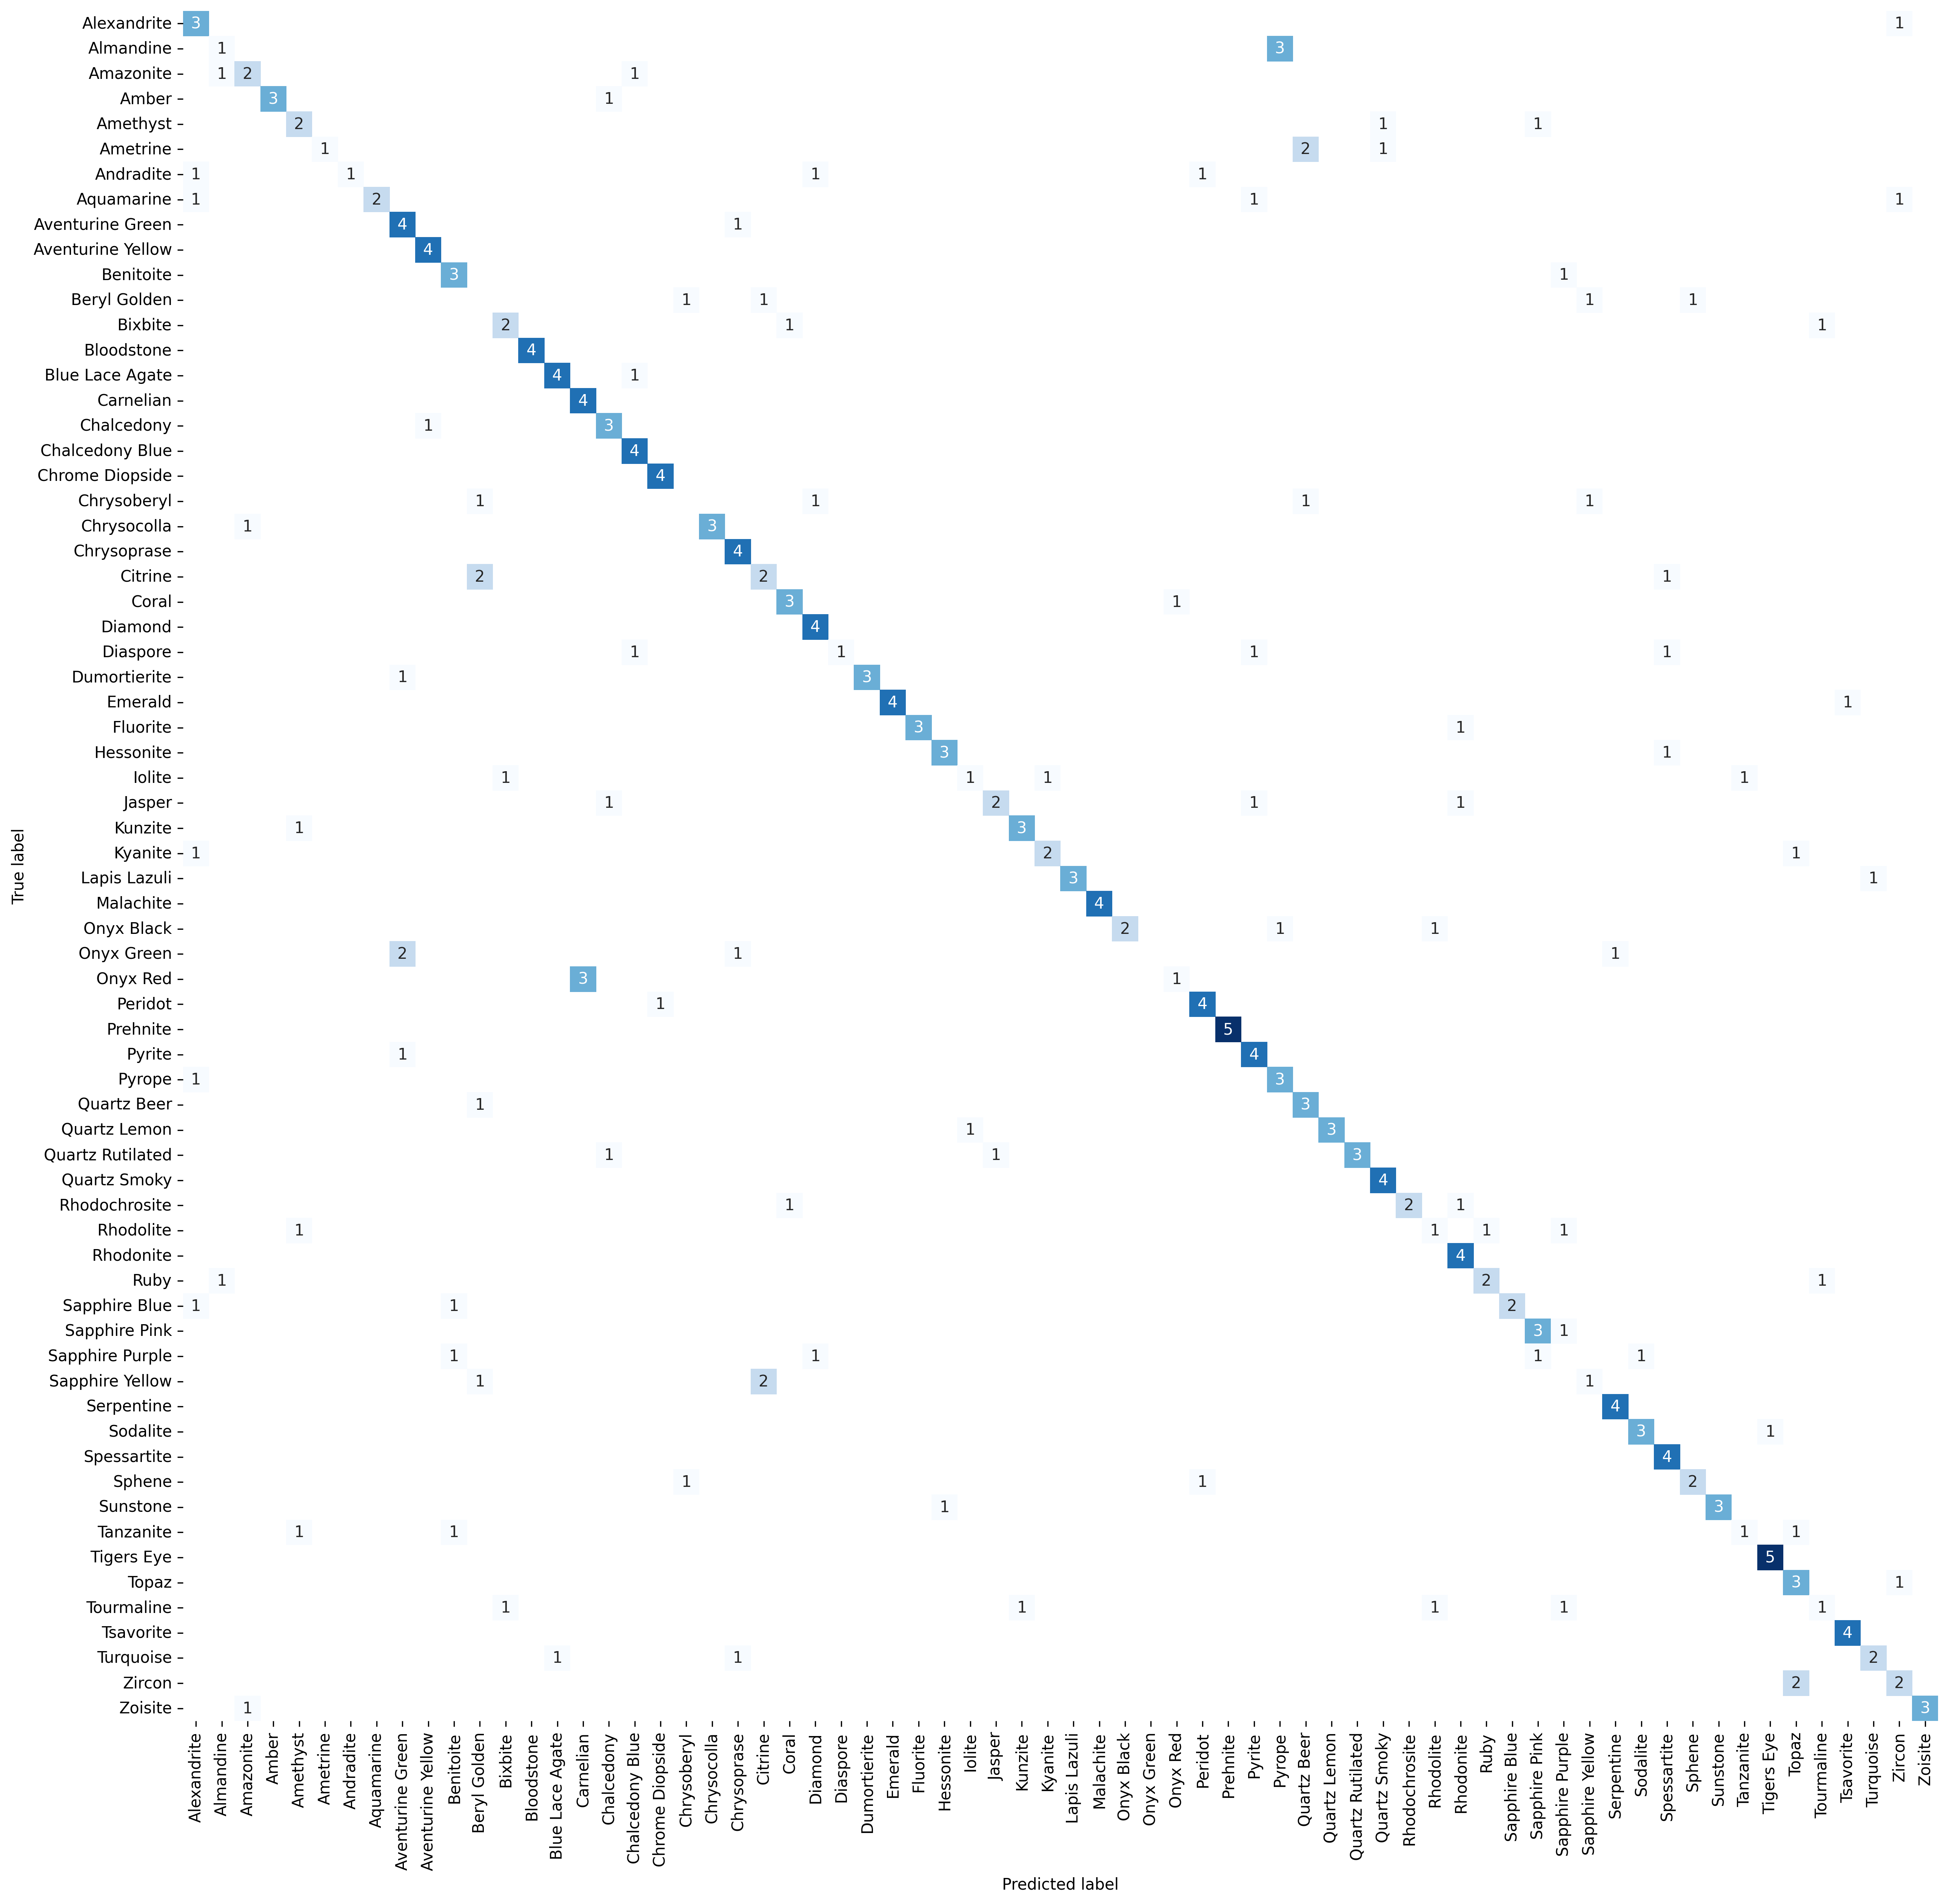

In [ ]:
gemstone_classes = image_datasets['test_masked'].classes
# Display confusion matrix of the best Random Forest model
fig= plt.figure(figsize = (20,20), dpi=300)
ax = plt.subplot()
cm = confusion_matrix(test_target, test_pred)
cm_mask = np.zeros((cm.shape[0], cm.shape[0]), dtype=int)
for i in range(cm.shape[0]):
    for j in range(cm.shape[0]):
        cm_mask[i][j] = cm[i][j] == 0
sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', cbar=False, mask=cm_mask)
plt.xlabel('Predicted label')
plt.ylabel('True label')
ax.set_xticks([x+0.5 for x in range(68)])
ax.set_xticklabels(sorted(gemstone_classes), rotation=90)
ax.set_yticks([x+0.5 for x in range(68)])
ax.set_yticklabels(sorted(gemstone_classes), rotation=0)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_target, test_pred, target_names=gemstone_classes))

                   precision    recall  f1-score   support

      Alexandrite       0.38      0.75      0.50         4
        Almandine       0.33      0.25      0.29         4
        Amazonite       0.50      0.50      0.50         4
            Amber       1.00      0.75      0.86         4
         Amethyst       0.40      0.50      0.44         4
         Ametrine       1.00      0.25      0.40         4
        Andradite       1.00      0.25      0.40         4
       Aquamarine       1.00      0.40      0.57         5
 Aventurine Green       0.50      0.80      0.62         5
Aventurine Yellow       0.80      1.00      0.89         4
        Benitoite       0.50      0.75      0.60         4
     Beryl Golden       0.00      0.00      0.00         4
          Bixbite       0.50      0.50      0.50         4
       Bloodstone       1.00      1.00      1.00         4
  Blue Lace Agate       0.80      0.80      0.80         5
        Carnelian       0.57      1.00      0.73       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


True classes: ['Chrome Diopside', 'Lapis Lazuli', 'Tourmaline', 'Onyx Black', 'Citrine', 'Sapphire Purple', 'Zircon', 'Almandine', 'Benitoite', 'Bloodstone', 'Onyx Red', 'Quartz Beer', 'Sunstone', 'Sapphire Yellow', 'Aventurine Green', 'Spessartite']
Predicted classes: ['Chrome Diopside', 'Turquoise', 'Sapphire Purple', 'Pyrope', 'Spessartite', 'Sapphire Pink', 'Zircon', 'Pyrope', 'Benitoite', 'Bloodstone', 'Carnelian', 'Quartz Beer', 'Sunstone', 'Citrine', 'Aventurine Green', 'Spessartite']


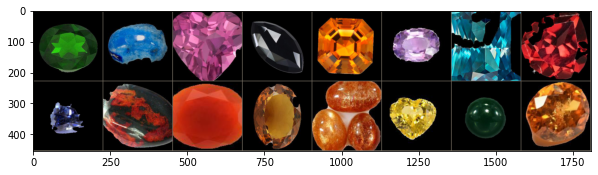

In [ ]:
# Define a function to display the image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.asarray(data_stds) * inp + np.asarray(data_means)
    inp = np.clip(inp, 0, 1)       # Clip to intensity outliers to [0, 1] range
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


# Get a batch of training data
first_inputs, first_classes = next(iter(dataloaders['test_masked']))

# Make a grid from batch
out = torchvision.utils.make_grid(first_inputs)

plt.figure(figsize=(10, 15))
imshow(out)
print('True classes: ' +str([class_names[x] for x in first_classes]))
print('Predicted classes: ' +str([class_names[y] for y in best_resnet50.predict(first_inputs)]))